In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#linear interpolation function
from scipy.interpolate import interp1d
from statistics import stdev, mean
import random

In [2]:
#imported dataframes
df1 =pd.read_csv("D://JohnCrawford/InternshipFiles/file1.csv")
df2 =pd.read_csv("D://JohnCrawford/InternshipFiles/file2.csv")
df3 =pd.read_csv("D://JohnCrawford/InternshipFiles/file3.csv") 
df4 =pd.read_csv("D://JohnCrawford/InternshipFiles/file4.csv")

In [3]:
#place all dataframes in a list to import into model
df_list = [df1, df2, df3, df4]


[     Unnamed: 0  layerId                               layerName  \
 0             0    49362                    Scene classification   
 1             1    49362                    Scene classification   
 2             2    49362                    Scene classification   
 3             3    49362                    Scene classification   
 4             4    49362                    Scene classification   
 ..          ...      ...                                     ...   
 451         451    49464  Normalized difference vegetation index   
 452         452    49464  Normalized difference vegetation index   
 453         453    49464  Normalized difference vegetation index   
 454         454    49464  Normalized difference vegetation index   
 455         455    49464  Normalized difference vegetation index   
 
          timestamp   latitude  longitude   value  
 0    1525478400000  34.297377 -97.427582  4.0000  
 1    1525910400000  34.297377 -97.427582  4.0000  
 2    15263424

In [4]:
#function condenses dataset into important columns and prepares for outlier detection
def data_split(df_list):
    df_n_list = []
    for df in df_list:
        df1=df[df.layerName=='Scene classification']
        df2=df[df.layerName=='Normalized difference vegetation index']
        #Scene classification values and NDVI were not in same row - this fixes that
        df_n=pd.merge(df1,df2, on='timestamp')
        df_n['time']=pd.to_datetime(df_n.timestamp, unit='ms')
        #keeps neccessary columns
        df_n=df_n[['time','layerName_x','value_x','layerName_y','value_y']]
        #new column added to observe trends with the day of year and the NDVI
        df_n['DOY']=df_n.time.dt.dayofyear
        df_n_list.append(df_n)
    return df_n_list

In [5]:
df_n_list = data_split(df_list)

In [64]:
df_n_list[0]

,time,layerName_x,value_x,layerName_y,value_y,DOY
0,2018-05-05,Scene classification,4.0,Normalized difference vegetation index,0.8387,125
1,2018-05-10,Scene classification,4.0,Normalized difference vegetation index,0.8292,130
2,2018-05-15,Scene classification,4.0,Normalized difference vegetation index,0.7119,135
3,2018-05-20,Scene classification,9.0,Normalized difference vegetation index,-0.0328,140
4,2018-05-25,Scene classification,8.0,Normalized difference vegetation index,0.2095,145
...,...,...,...,...,...,...
223,2021-06-08,Scene classification,4.0,Normalized difference vegetation index,0.8028,159
224,2021-06-13,Scene classification,4.0,Normalized difference vegetation index,0.7372,164
225,2021-06-18,Scene classification,4.0,Normalized difference vegetation index,0.7733,169
226,2021-06-23,Scene classification,4.0,Normalized difference vegetation index,0.6592,174


In [7]:
#function goes through NDVI values and calculates sliding window means and standard deviations and filters any NDVI values
#that are more than 2 standard deviations away from the mean
def Outliers(df_n_list):
    df_o_list = []
    df_before_list = []
    Outlier_list = []
    for df in df_n_list:
        #filters to Scene classifications of "vegetation" and "not vegetated" to avoid cloud cover or other possible sattelite errors
        df_o = df[(df.value_x==4)|(df.value_x==5)]
        rolling_window = 4
        #chose rolling mean and STD of previous 4 values because changes in NDVI values for decidious trees can happen quickly
        df_o['Rolling Mean'] = df_o['value_y'].rolling(rolling_window).mean()
        df_o['STD'] = df_o['value_y'].std()
        df_o['Rolling STD'] = df_o['value_y'].rolling(rolling_window).std()
        #shifts these values so each NDVI is lined up with the previous 4-day average, because if that value is included in the 
        #calculation outliers rarely get detected
        df_o['Rolling Mean'] = df_o['Rolling Mean'].shift(1)
        df_o['Rolling STD'] = df_o['Rolling STD'].shift(1)
    
        DropList = []
        #loop to detect outliers 2 rolling std away from rolling average
        for x in df_o.index:
            #if the data doesn't have a rolling mean (first 4 values) then use the first one caclulated at an index of 4
            #this won't be precise but it preserves neccessary data and gets rid of any egregious outliers
            if df_o.loc[x, 'Rolling Mean'] == 'NaN':
                mean = df_o['Rolling Mean'].iloc[rolling_window]
                std = df_o['Rolling STD'].iloc[rolling_window]
                upper_bound = mean + (2 * std)
                lower_bound = mean - (2 * std)
                if ((df_o.loc[x, 'value_y']) < lower_bound) or (df_o.loc[x, 'value_y']) > upper_bound:
                    #append index to a list if past the upper and lower bounds
                    DropList.append(x)
            else:
                #caclulations for most of the data
                mean = df_o.loc[x, 'Rolling Mean']
                std = df_o.loc[x, 'Rolling STD']
                upper_bound = mean + (2 * std)
                lower_bound = mean - (2 * std)
                if ((df_o.loc[x, 'value_y']) < lower_bound) or (df_o.loc[x, 'value_y']) > upper_bound:
                    DropList.append(x)
        #new dataframe without outliers
        df_o_drop = df_o.drop(DropList)
        df_o_list.append(df_o_drop)
        df_before_list.append(df_o)
        Outlier_list.append(DropList)
        #save the outlier list and previous dataset to view changes/results
    return df_o_list, df_before_list, Outlier_list

In [8]:
df_o_list, df_before_list, Outliers = Outliers(df_n_list)



<ipython-input-7-b6231ff80da4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_o['Rolling Mean'] = df_o['value_y'].rolling(rolling_window).mean()
<ipython-input-7-b6231ff80da4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_o['STD'] = df_o['value_y'].std()
<ipython-input-7-b6231ff80da4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [9]:
df_o_list[0]

,time,layerName_x,value_x,layerName_y,value_y,DOY,Rolling Mean,STD,Rolling STD
0,2018-05-05,Scene classification,4.0,Normalized difference vegetation index,0.8387,125,NaN,0.185619,NaN
1,2018-05-10,Scene classification,4.0,Normalized difference vegetation index,0.8292,130,NaN,0.185619,NaN
2,2018-05-15,Scene classification,4.0,Normalized difference vegetation index,0.7119,135,NaN,0.185619,NaN
5,2018-05-30,Scene classification,4.0,Normalized difference vegetation index,0.8248,150,NaN,0.185619,NaN
7,2018-06-09,Scene classification,4.0,Normalized difference vegetation index,0.8127,160,0.801150,0.185619,0.059782
...,...,...,...,...,...,...,...,...,...
217,2021-05-09,Scene classification,4.0,Normalized difference vegetation index,0.7644,129,0.451600,0.185619,0.212199
221,2021-05-29,Scene classification,4.0,Normalized difference vegetation index,0.8143,149,0.545800,0.185619,0.253863
223,2021-06-08,Scene classification,4.0,Normalized difference vegetation index,0.8028,159,0.658775,0.185619,0.245453
224,2021-06-13,Scene classification,4.0,Normalized difference vegetation index,0.7372,164,0.786400,0.185619,0.026004


In [10]:
#function to plot before/after of outlier detection
def plot_outliers(df_before, df_after, title):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 8))
    f.suptitle(title)
    ax1.plot(df_before.DOY,df_before.value_y,'bo')
    ax1.set_xlabel('DOY')
    ax1.set_ylabel('NDVI')
    ax1.title.set_text('before')
    
    ax2.plot(df_after.DOY,df_after.value_y,'bo')
    ax2.set_xlabel('DOY')
    ax2.set_ylabel('NDVI')
    ax2.title.set_text('after')


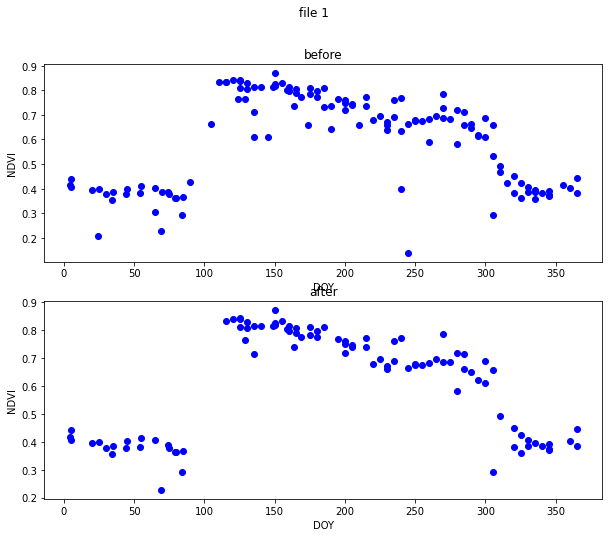

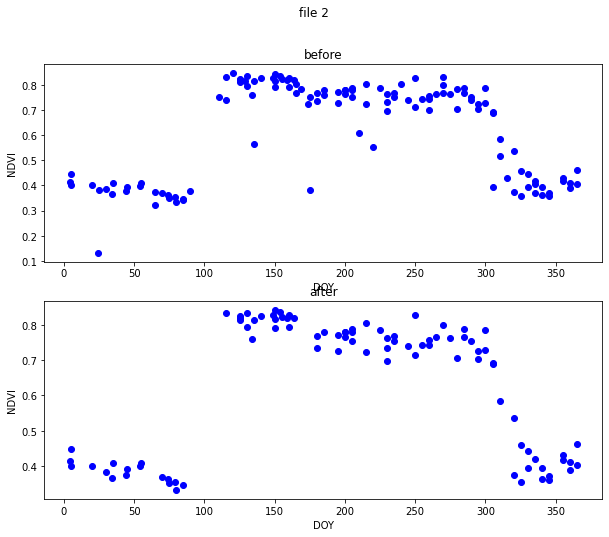

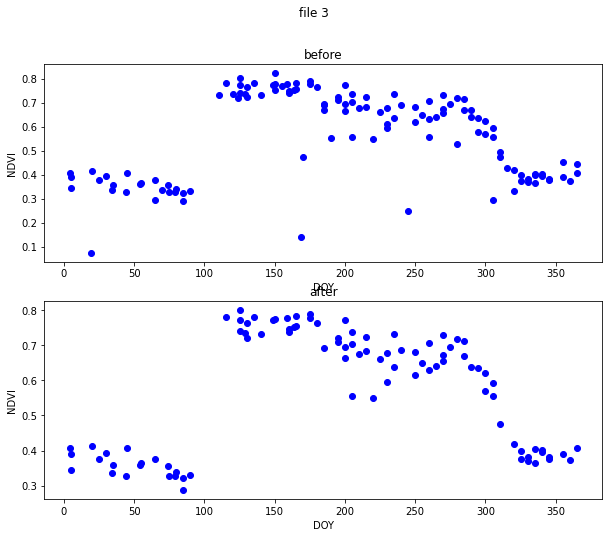

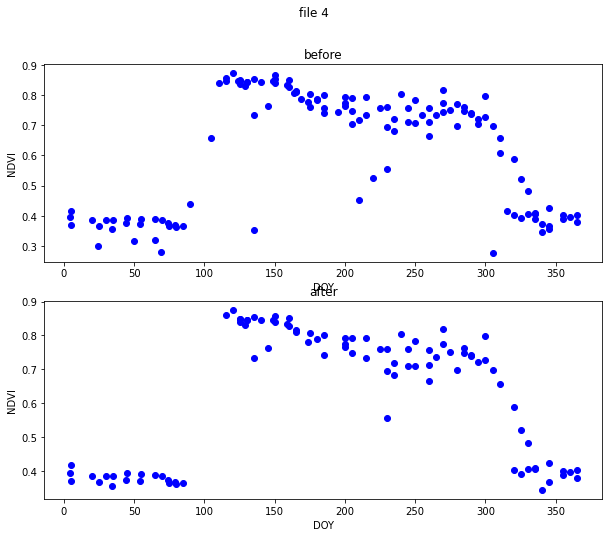

In [11]:
plot_outliers(df_before_list[0], df_o_list[0], 'file 1')
plot_outliers(df_before_list[1], df_o_list[1], 'file 2')
plot_outliers(df_before_list[2], df_o_list[2], 'file 3')
plot_outliers(df_before_list[3], df_o_list[3], 'file 4')

In [12]:
df_o_list[0].index[-1]

225

In [13]:
#model needs to have all dataframes have the same row length
#find the minimum of the maximum indicies for all the datasets and condense others down to that length

def endpoints(df_o_list):
    first_index = []
    last_index = []
    for df in df_o_list:
        first_index.append(df.index[0])
        last_index.append(df.index[-1])
    max_value = min(last_index)
    min_value = max(first_index)
    return max_value, min_value

#loop that goes through and drops extra rows to get all dataframes the same length
def same_shape(df_o_list):
    mismatch = True
    while mismatch == True:
        max_value, min_value = endpoints(df_o_list)
        for df in df_o_list:
            for x in df.index:
                if x > max_value:
                    df.drop(x, inplace = True)
                if x < min_value:
                    df.drop(x, inplace = True)
        for df in df_o_list:
            if df.index[-1] != max_value or df.index[0] != min_value:
                mismatch = True
            else:
                mismatch = False
    return df_o_list
df_o_list = same_shape(df_o_list)


In [122]:
df_o_list[0]

,time,layerName_x,value_x,layerName_y,value_y,DOY,Rolling Mean,STD,Rolling STD
0,2018-05-05,Scene classification,4.0,Normalized difference vegetation index,0.8387,125,NaN,0.185619,NaN
1,2018-05-10,Scene classification,4.0,Normalized difference vegetation index,0.8292,130,NaN,0.185619,NaN
2,2018-05-15,Scene classification,4.0,Normalized difference vegetation index,0.7119,135,NaN,0.185619,NaN
5,2018-05-30,Scene classification,4.0,Normalized difference vegetation index,0.8248,150,NaN,0.185619,NaN
7,2018-06-09,Scene classification,4.0,Normalized difference vegetation index,0.8127,160,0.801150,0.185619,0.059782
...,...,...,...,...,...,...,...,...,...
208,2021-03-20,Scene classification,5.0,Normalized difference vegetation index,0.3624,79,0.343625,0.185619,0.077334
209,2021-03-25,Scene classification,5.0,Normalized difference vegetation index,0.2923,84,0.339925,0.185619,0.075525
217,2021-05-09,Scene classification,4.0,Normalized difference vegetation index,0.7644,129,0.451600,0.185619,0.212199
221,2021-05-29,Scene classification,4.0,Normalized difference vegetation index,0.8143,149,0.545800,0.185619,0.253863


In [105]:
#function to linear interpolate the missing values; outlier dataframe list inputted
def Interpolation(df_o_list):
    df_i_list = []
    for df in df_o_list:
        InterpIndex = []
        InterpTime = []
        InterpDOY = []
        #loop that cycles through all index values and if not found in filtered dataset, it adds to a list to go to interpolation
        for x in range(df.index[-1]):
            try:
                (df.loc[x, 'time'])
            except (KeyError):
                #make sure value is within the interpolation range (don't want to do extrapolation - not very accurate)
                #if (df.index[0] <= x) and (df.index[-1] >= x):
                InterpIndex.append(x)
                time = df_n_list[0].loc[x, 'time']
                DOY = int(df_n_list[0].loc[x, 'DOY'])
                InterpTime.append(time)
                InterpDOY.append(DOY)
                 
            #data to input into interpolation function
        X = df.index
        Y = df.value_y
        y_interp = interp1d(X, Y)
        #create a list of interpolated values with indicies that were filtered out
        ListInterpY = y_interp(InterpIndex)
        #create dataframe of these interpolated values
        Interp_df = pd.DataFrame(index = InterpIndex)
        Interp_df['time'] = InterpTime
        Interp_df['value_y'] = ListInterpY
        Interp_df['DOY'] = InterpDOY
        df_i_list.append(Interp_df)
    return df_i_list

In [106]:
df_i_list = Interpolation(df_o_list)

df_i_list[0]

,time,value_y,DOY
3,2018-05-20,0.749533,140
4,2018-05-25,0.787167,145
6,2018-06-04,0.818750,155
9,2018-06-19,0.794450,170
13,2018-07-09,0.788650,190
...,...,...,...
216,2021-05-04,0.705388,124
218,2021-05-14,0.776875,134
219,2021-05-19,0.789350,139
220,2021-05-24,0.801825,144


In [107]:
#function to combine interpolated values with outlier filtered values
def merge_data(df_o_list, df_i_list):
    df__list = []
    for x in range(len(df_o_list)):  
        frames = [df_o_list[x], df_i_list[x]]
        df = pd.concat(frames)
        df.sort_index(inplace = True)
        df.drop_duplicates(inplace = True)
        df.reset_index(drop = True, inplace=True)
        #fill blank values and indicate interpolated values
        values = {'layerName_x': "Scene classification", 'value_x': "Interpolated", 'layerName_y': "Normalized difference vegetation index"}
        df.fillna(value = values, inplace = True)
        #drop previous, now unnecessary columns
        cols_to_drop = ['Rolling Mean','STD', 'Rolling STD' ]
        df.drop(cols_to_drop, axis = 1, inplace =True)
        df__list.append(df)
    return df__list

In [108]:
df__list = merge_data(df_o_list, df_i_list)

#all dataframes contain the same amount of rows now - same shape for model

In [110]:

df__list[2]

,time,layerName_x,value_x,layerName_y,value_y,DOY
0,2018-05-05,Scene classification,4,Normalized difference vegetation index,0.800600,125
1,2018-05-10,Scene classification,4,Normalized difference vegetation index,0.763400,130
2,2018-05-15,Scene classification,Interpolated,Normalized difference vegetation index,0.766550,135
3,2018-05-20,Scene classification,Interpolated,Normalized difference vegetation index,0.769700,140
4,2018-05-25,Scene classification,Interpolated,Normalized difference vegetation index,0.772850,145
...,...,...,...,...,...,...
219,2021-05-19,Scene classification,Interpolated,Normalized difference vegetation index,0.753050,139
220,2021-05-24,Scene classification,Interpolated,Normalized difference vegetation index,0.762225,144
221,2021-05-29,Scene classification,4,Normalized difference vegetation index,0.771400,149
222,2021-06-03,Scene classification,Interpolated,Normalized difference vegetation index,0.774350,154


In [111]:
#format dataframe into the format ROCKET Classification model takes
def model_prep(df__list):
    df_m_list = []
    for df in df__list:
        #drop all columns except index and NDVI
        cols_to_drop = ['time', 'layerName_x', 'value_x', 'layerName_y', 'DOY']
        df.drop(cols_to_drop, axis = 1, inplace =True)
        Series = df.squeeze()
        #create new dataframe with two columns, the time series in array form, and it's classifcation (0 = deciduous 1 = evergreen)
        df_model = pd.DataFrame(columns = ['dim_0', 'class_val'])
        #add data to columns (these files are all from deciduous trees, hence the 0 classifier)
        df_model.loc[len(df.index)] = [Series, 0]
        df_m_list.append(df_model)
    return df_m_list

In [112]:
df_m_list = model_prep(df__list)

In [113]:
#create sample evergreen NDVI datasets to use in model (static NDVI)
def sample_evergreen(noise = 0.0001, NDVI = 0.78):
    #create some noise to simulate actual evergreen time series - not just straight line
    sample = len(df__list[0].index)
    x = np.arange(sample) 
    noise = 0.0001* np.asarray(random.sample(range(-500,500),sample))
    #create base NDVI value to add noise to
    Mean_NDVI = [(NDVI)] * len(df__list[0].index)
    Mean_NDVI = np.array(Mean_NDVI)
    Y_evergreen = np.add(Mean_NDVI, noise)
    #create dataframe with this simulated time series
    df_e = pd.DataFrame(data = Y_evergreen)
    #convert it to the form ROCKET takes as input
    Series = df_e.squeeze()
    df_e = pd.DataFrame(columns = ['dim_0', 'class_val'])
    #class_val of 1 instead of 0 for evergreen
    df_e.loc[len(df_e.index)] = [Series, 1]
    return df_e
#noise calculation is random so generate 4 different evergreen datasets
x = (len(df_m_list))
df_e_list = []
while x > 0:
    df = sample_evergreen()
    df_e_list.append(df)
    x -= 1


In [114]:
#create train dataset with ~80% of dataframes from each category
frames = []
train_sample = int(round(0.8 * (len(df_m_list)), 0))
print(train_sample)
for x in df_m_list[0:train_sample]:
    frames.append(x)
for x in df_e_list[0:train_sample]:
    frames.append(x)
df_train = pd.concat(frames)
df_train.reset_index(drop = True, inplace = True)
df_train

3


,dim_0,class_val
0,0 0.838700 1 0.829200 2 0.71190...,0
1,0 0.8127 1 0.7952 2 0.7941 3 ...,0
2,0 0.800600 1 0.763400 2 0.76655...,0
3,0 0.7827 1 0.7718 2 0.7838 3 ...,1
4,0 0.7759 1 0.7320 2 0.7859 3 ...,1
5,0 0.7598 1 0.7387 2 0.8010 3 ...,1


In [115]:
#create test dataset with remaining dataframes
frames = []
for x in df_m_list[train_sample:]:
    frames.append(x)
for x in df_e_list[train_sample:]:
    frames.append(x)
df_test = pd.concat(frames)
df_test.reset_index(drop = True, inplace = True)
df_test

,dim_0,class_val
0,0 0.84860 1 0.84400 2 0.73400 3...,0
1,0 0.7616 1 0.7637 2 0.7949 3 ...,1


In [116]:
#model requires y values (classifiers) in numpy arrays and x values in same dataframe
y_train = df_train.class_val.to_numpy('<U1')
y_test = df_test.class_val.to_numpy('<U1')
X_train = df_train.drop('class_val', axis = 1)
x_test = df_test.drop('class_val', axis = 1)

In [117]:
print(y_train)
X_train.head(10)

['0' '0' '0' '1' '1' '1']


,dim_0
0,0 0.838700 1 0.829200 2 0.71190...
1,0 0.8127 1 0.7952 2 0.7941 3 ...
2,0 0.800600 1 0.763400 2 0.76655...
3,0 0.7827 1 0.7718 2 0.7838 3 ...
4,0 0.7759 1 0.7320 2 0.7859 3 ...
5,0 0.7598 1 0.7387 2 0.8010 3 ...


In [118]:
#import the Rocket model and linear classfication
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
#import Rocket with 10,000 kernels and a random state
rocket = Rocket(num_kernels=10000, random_state=111) 
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)
X_train_transform.shape

(6, 20000)

In [119]:
#import classifier
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [120]:
#transform test dataframe into proper format to retrieve classifier score
X_test_transform = rocket.transform(x_test)
classifier.score(X_test_transform, y_test)
#model only had two tests to test model accuracy but it classified both correctly

1.0

In [121]:
#predict the classification of test (0 = deciduous 1 = evergreen)
y_pred = classifier.predict(X_test_transform)
print(y_pred)

['0' '1']
